In [22]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import network_rmse, plot_estimates, plot_rmse, plot_traj, rmse
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Simulation parameters
RUNS = 10
NETWORK_FILE = "./networks/network_15_6.pkl"
FILEPATH_CSV = "./sim_results/avg_rmse.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 200
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
TRAJ_MODEL = CAModel(q, r)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 10  # RWM process noise scaling constant
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

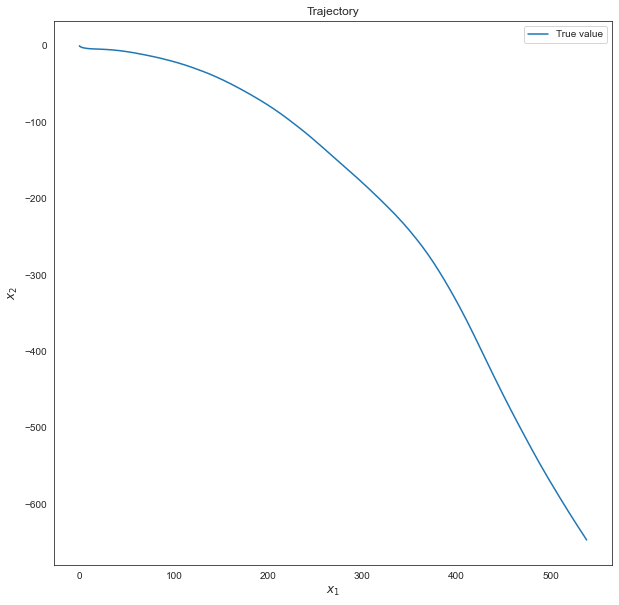

In [25]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

plot_traj(traj)

In [42]:
rmse_rwm1 = np.zeros((ndat, 2))
rmse_rwm2 = np.zeros((ndat, 2))

# No coop nodes
rmse_rwmnc = np.zeros((ndat, 2))
rmse_camnc = np.zeros((ndat, 2))
rmse_cvmnc = np.zeros((ndat, 2))

# Run simulations
for i in range(RUNS):
    # Initialize network
    kfs = [
        KalmanFilter(RWModel(20 * q, r), lambda_expf=expf),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CVModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
        KalmanFilter(CAModel(q, r)),
    ]

    ###
    rwmnc = KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf)
    cvmnc = KalmanFilter(CVModel(q, r))
    camnc = KalmanFilter(CAModel(q, r))

    # Load network topology file
    kfn = None
    with open(NETWORK_FILE, "rb") as f:
        kfn = pickle.load(f)
    kfn.assign(init=kfs)
    kfn.generate_txt_labels()

    # Add observation noise for each node
    R = kfn.observation_covs()
    traj.add_obs_noise(R)

    # Run estimation
    for yt in traj.observations:
        kfn.time_step(
            yt,
            predict=True,
            update=True,
            adapt=True,
            combine=True,
            reset_strategy="mean",
            reset_thresh=reset_thresh,
            c=0.95,
        )

        rwmnc.predict()
        rwmnc.update(yt[0], log=True)

        cvmnc.predict()
        cvmnc.update(yt[5], log=True)

        camnc.predict()
        camnc.update(yt[4], log=True)

    # Save results
    RWM_1 = kfs[0]
    RWM_2 = kfs[11]

    rmse_rwm1 += rmse(traj.X[:, :2], RWM_1.history[:, :2], n=ndat)
    rmse_rwm2 += rmse(traj.X[:, :2], RWM_2.history[:, :2], n=ndat)

    rmse_rwmnc += rmse(traj.X[:, :2], rwmnc.history[:, :2], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :2], cvmnc.history[:, :2], n=ndat)
    rmse_camnc += rmse(traj.X[:, :2], camnc.history[:, :2], n=ndat)

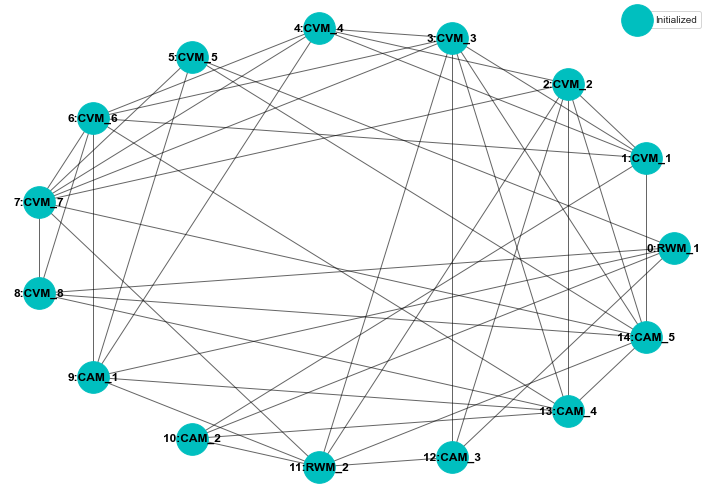

In [43]:
kfn.draw_network()

In [44]:
# Average the results
rmse_rwm1 /= RUNS
rmse_rwm2 /= RUNS

rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS

No handles with labels found to put in legend.


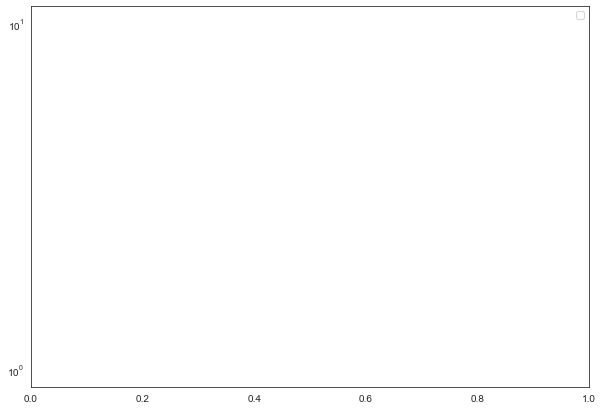

In [45]:
plt.figure(figsize=(10, 7))
# plt.plot(rmse_rwm1[:, 0], label="RWM1")
# plt.plot(rmse_rwm2[:, 0], label="RWM2")

# plt.plot(rmse_rwmnc[:, 0], label="RWMNC")
# plt.plot(rmse_cvmnc[:, 0], label="CVMNC")
# plt.plot(rmse_camnc[:, 0], label="CAMNC")

plt.yscale("log", base=10)
plt.legend()
plt.show()

In [46]:
# CSV column labels
cols = []
for n in chain(kfn._txt_labels, ["RWM_NC", "CVM_NC", "CAM_NC"]):
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

data = network_rmse(kfn, traj, ndat, 2, rwmnc, cvmnc, camnc)

In [47]:
# Generate CSV files
df = pd.DataFrame(data=data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_1_x1,RWM_1_x2,CVM_1_x1,CVM_1_x2,CVM_2_x1,CVM_2_x2,CVM_3_x1,CVM_3_x2,CVM_4_x1,CVM_4_x2,...,CAM_4_x1,CAM_4_x2,CAM_5_x1,CAM_5_x2,RWM_NC_x1,RWM_NC_x2,CVM_NC_x1,CVM_NC_x2,CAM_NC_x1,CAM_NC_x2
0,0.158833,0.045035,0.215550,0.080307,0.145271,0.054798,0.052623,0.007668,0.000388,0.083748,...,0.194155,0.104120,0.225561,0.145631,1.328466,0.187440,0.470037,1.232428,1.348203,1.408913
1,0.340016,0.056914,0.191084,0.319566,0.293921,0.390859,0.244062,0.374248,0.104314,0.376636,...,0.373000,0.095435,0.438242,0.327133,1.161345,0.481825,0.911736,0.963263,1.411767,2.489523
2,0.277667,0.161268,0.170351,0.292601,0.285174,0.340225,0.269935,0.336105,0.195166,0.342761,...,0.332543,0.083306,0.418193,0.304546,1.086964,0.458159,0.831418,1.043660,1.355465,2.241731
3,0.269320,0.142086,0.219548,0.276016,0.264338,0.304076,0.253157,0.297076,0.278735,0.311039,...,0.307642,0.090316,0.365620,0.264830,0.982927,0.427161,0.902239,1.192198,2.147614,2.012706
4,0.276964,0.195329,0.300372,0.252122,0.336716,0.280388,0.337732,0.274129,0.338314,0.279295,...,0.392937,0.173969,0.464198,0.283954,0.888547,0.387168,1.007899,1.152785,1.951339,1.891127


In [48]:
x = camnc.to_dataframe(traj)
x.head()

,x1_est,x2_est,x3_est,x4_est,x5_est,x6_est,x1_std,x2_std,x3_std,x4_std,x5_std,x6_std,x1_real,x2_real,x3_real,x4_real,x5_real,x6_real,reset
0,-1.348994,-1.406511,-0.899329,-0.937674,-0.299776,-0.312558,1.299512,1.299512,31.634642,31.634642,29.815640,29.815640,-0.000791,0.002402,-0.000887,0.005461,0.000620,0.011725,0.0
1,1.468594,-3.217070,3.796342,-2.176001,1.969768,-0.733155,1.299420,1.299420,8.062125,8.062125,15.395387,15.395387,-0.003997,0.009448,-0.006131,0.004724,-0.007776,-0.009533,0.0
2,1.219803,1.644363,-1.574216,7.895551,-2.824994,6.324569,1.295666,1.295666,3.213564,3.213564,3.066118,3.066118,-0.015381,0.007103,-0.016949,-0.010761,-0.011945,-0.017084,0.0
3,3.560140,1.049510,1.445322,1.435463,-0.056955,0.269604,1.265194,1.265194,2.017348,2.017348,1.285492,1.285492,-0.036682,-0.012503,-0.025055,-0.029005,-0.007023,-0.025163,0.0
4,-0.831985,-1.346055,-3.654820,-1.737958,-1.920291,-1.002511,1.222454,1.222454,1.443631,1.443631,0.691286,0.691286,-0.064107,-0.050729,-0.031885,-0.045316,-0.010244,-0.013833,0.0


In [49]:
len(RWM_1._reset_log)

108

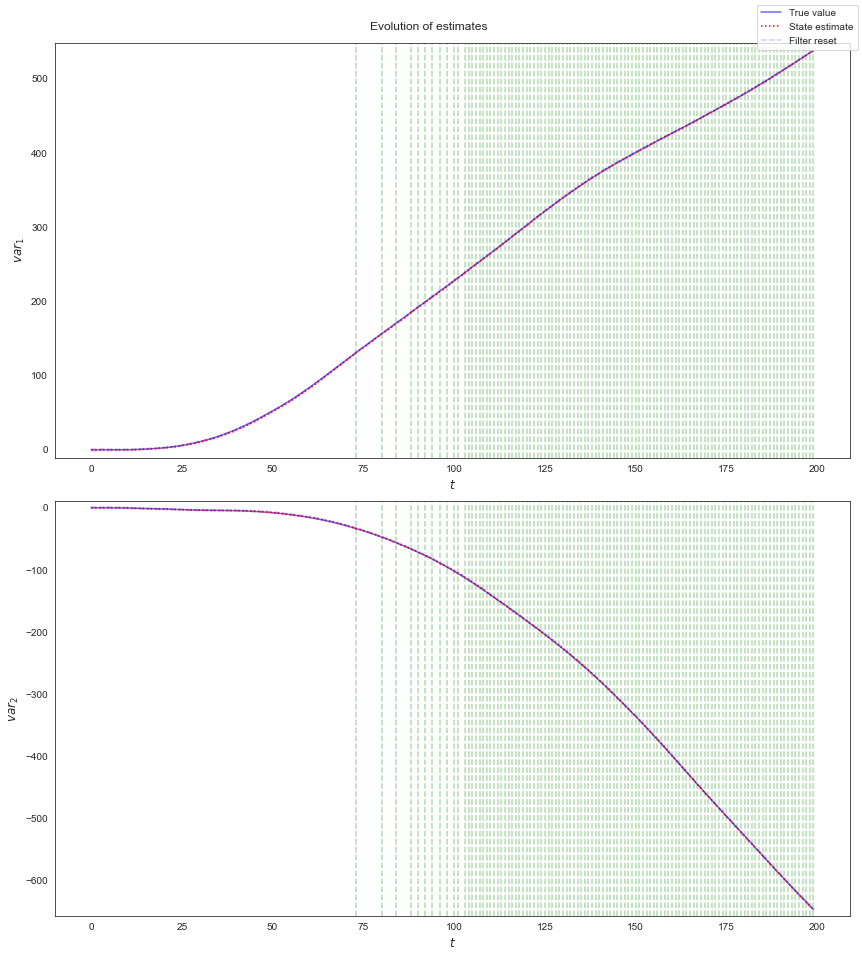

In [50]:
plot_estimates(RWM_1, traj)

In [62]:
(1 / 0.95) ** 200

28528.50031153893